In [173]:
import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np
from moviepy.editor import VideoFileClip

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Loading Test Images

The following libraries are used.  `cv2` is for OpenCV.
The following `show_image` function is used to display images.


In [175]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

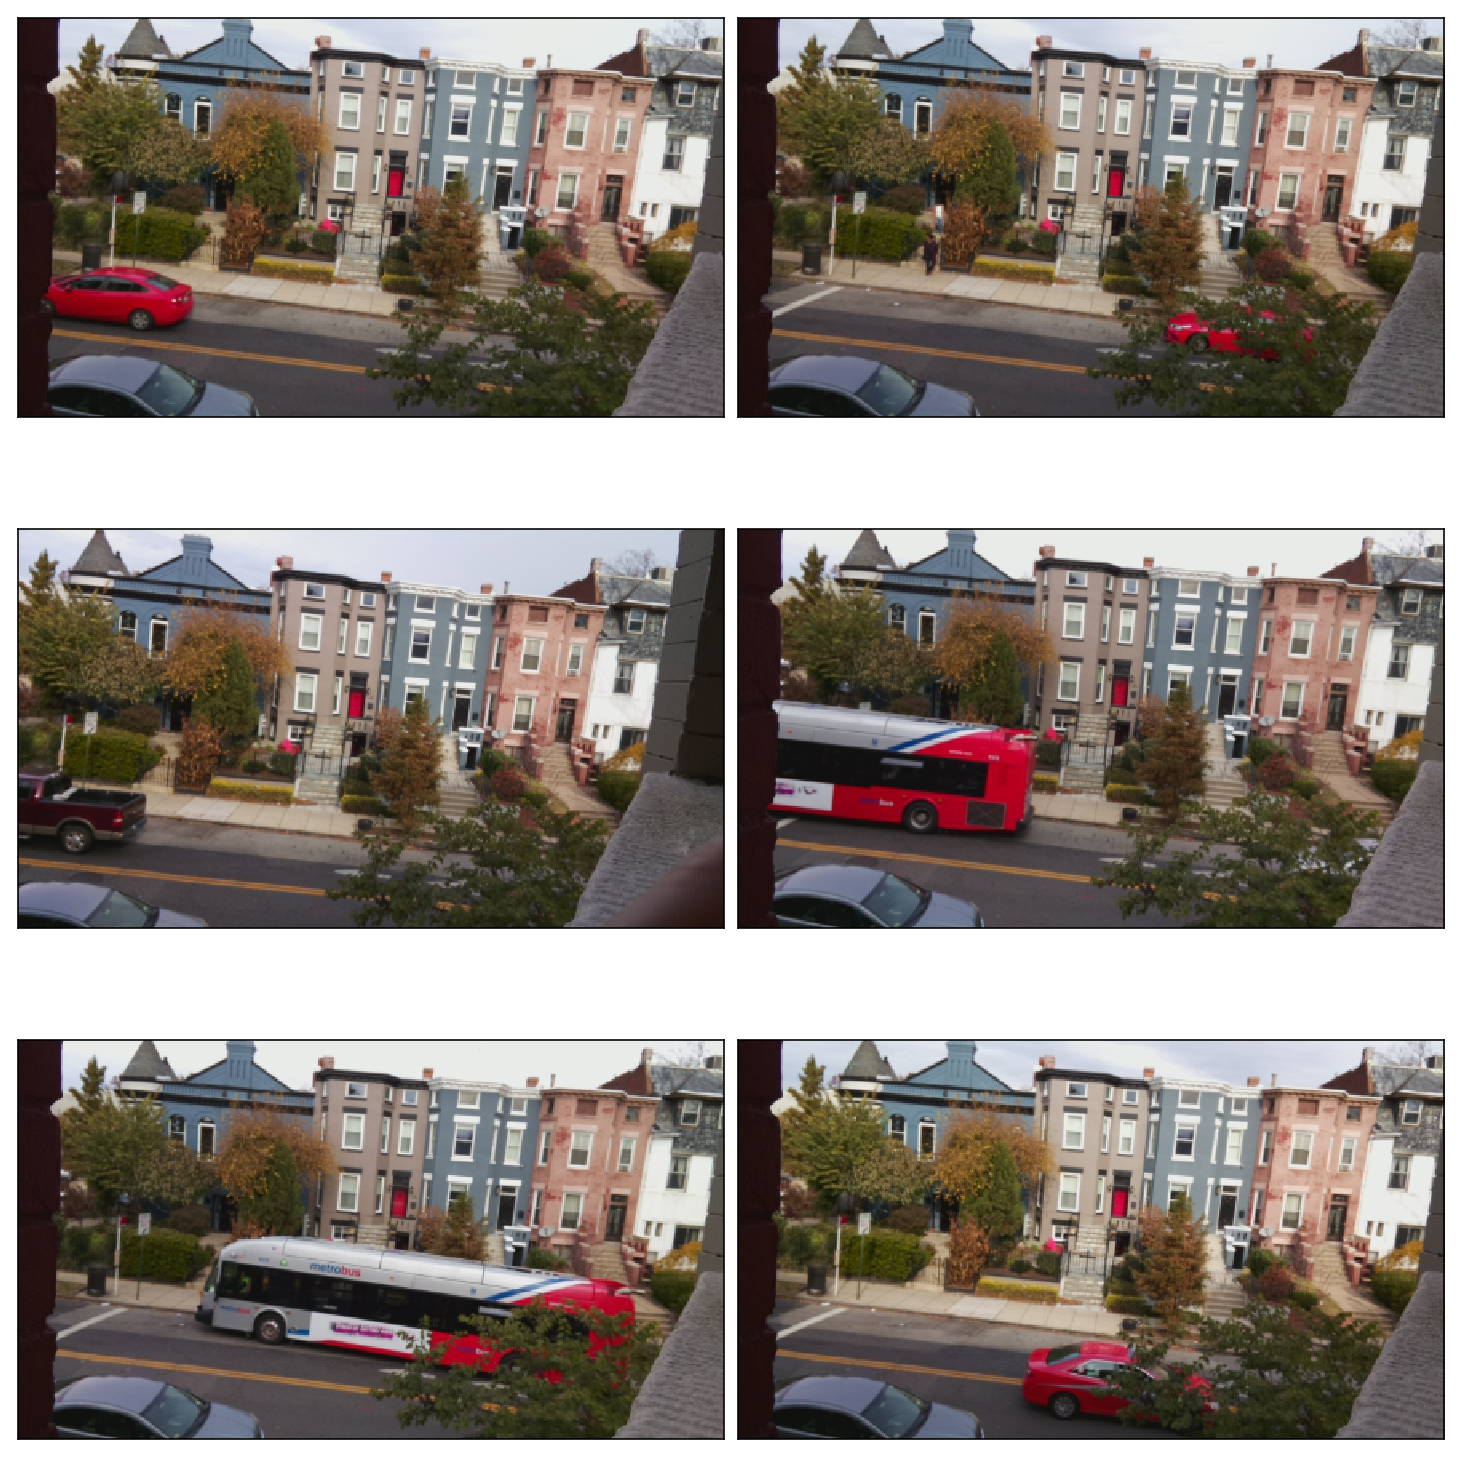

In [176]:
test_images = [plt.imread(path) for path in glob.glob('StreetExamples/*.jpg')]

show_images(test_images)

## Color Selection

### HSL and HSV Color Space

Using `cv2.cvtColor`, we can convert RGB image into different color space.  For example, [HSL and HSV color space](https://en.wikipedia.org/wiki/HSL_and_HSV).

<img src='images/hsl-hsv.png' width='50%'>

Image Source: [https://commons.wikimedia.org/wiki/File:Hsl-hsv_models.svg](https://commons.wikimedia.org/wiki/File:Hsl-hsv_models.svg)


### HSV Color Space

How does it look when RGB images are converted into HSV color space?
Is yellow easily detected?


<IPython.core.display.Javascript object>


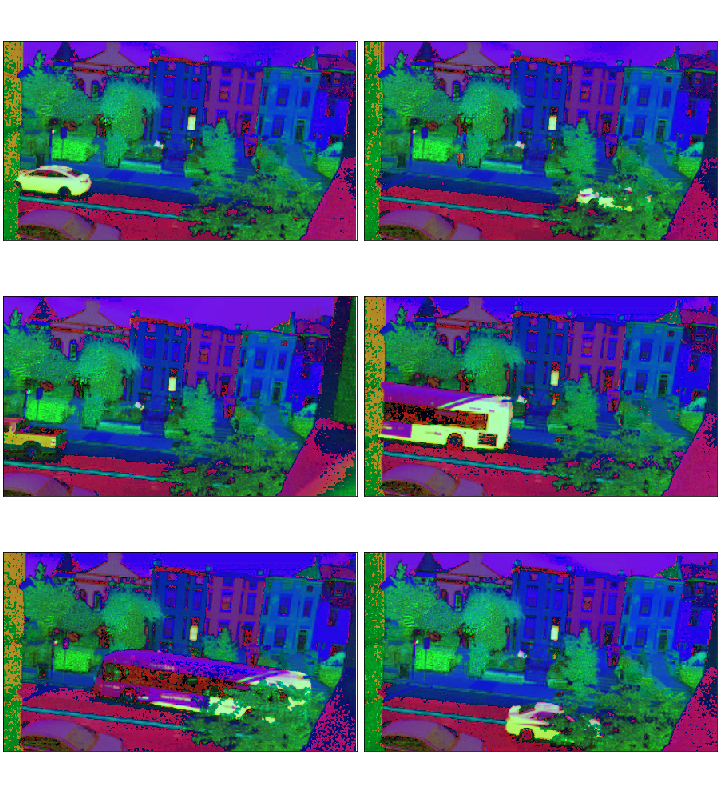

In [177]:
%matplotlib notebook

def convert_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
show_images(list(map(convert_hsv, test_images )))
 

 
Let's build a filter to select those yellow lines. I want to select particular range of each channels (Hue, Saturation and Light). You can use the mouse-over above to see what Hue Saturation and Light to use.
  
- Use `cv2.inRange` to filter  the yellow color.  
  The function returns 255 when the filter conditon is satisfied.  Otherwise, it returns 0.
- Use `cv2.bitwise_and` to apply the combined mask onto the original RGB image


<IPython.core.display.Javascript object>


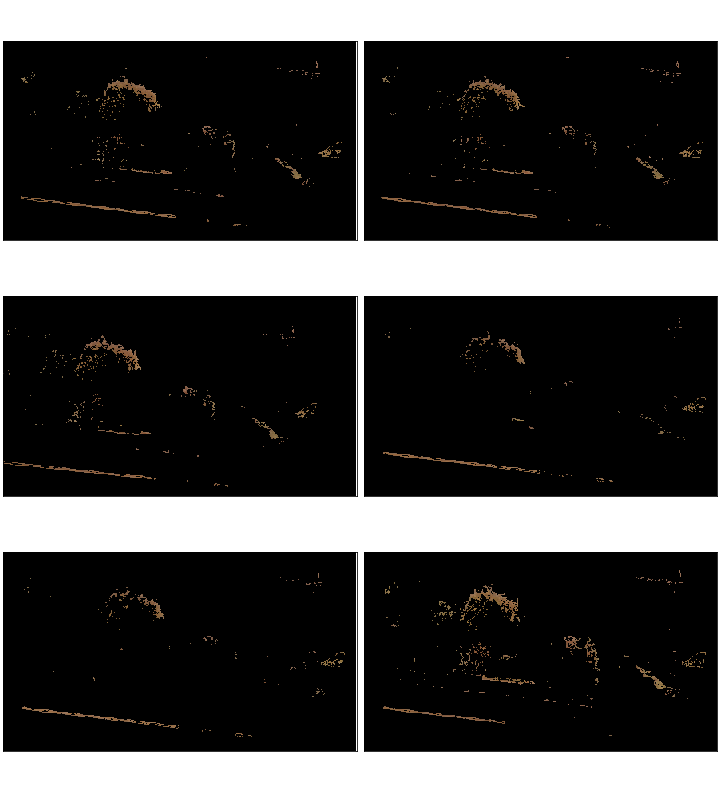

In [178]:
def select_yellow(image):
    converted = convert_hsv(image)
    # yellow color mask
    #                  Hue  Sat  Light
    lower = np.uint8([ 10,  100, 120])  
    upper = np.uint8([ 20, 160, 160])     
 
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = yellow_mask 
    return cv2.bitwise_and(image, image, mask = mask)

yellow_images = list(map(select_yellow, test_images))

show_images(yellow_images)

 Now the yellow lines are the dominant feature
    

## Canny Edge Detection

The Canny edge detector was developed by John F. Canny in 1986.  

We want to detect edges in order to find straight lines especially lane lines.  For this, 

- use `cv2.cvtColor` to convert images into gray scale
- use `cv2.GaussianBlur` to smooth out rough edges 
- use `cv2.Canny` to find edges

Let's take a look at each step in details.

Note: [Canny Edge Detection Wikipedia](https://en.wikipedia.org/wiki/Canny_edge_detector) has a good description in good details.

    
### Gray Scaling

The images should be converted into gray scaled ones in order to detect shapes (edges) in the images.  This is because the Canny edge detection measures the magnitude of pixel intensity changes or gradients (more on this later).

Here, I'm converting the white and yellow line images from the above into gray scale for edge detection.

<IPython.core.display.Javascript object>


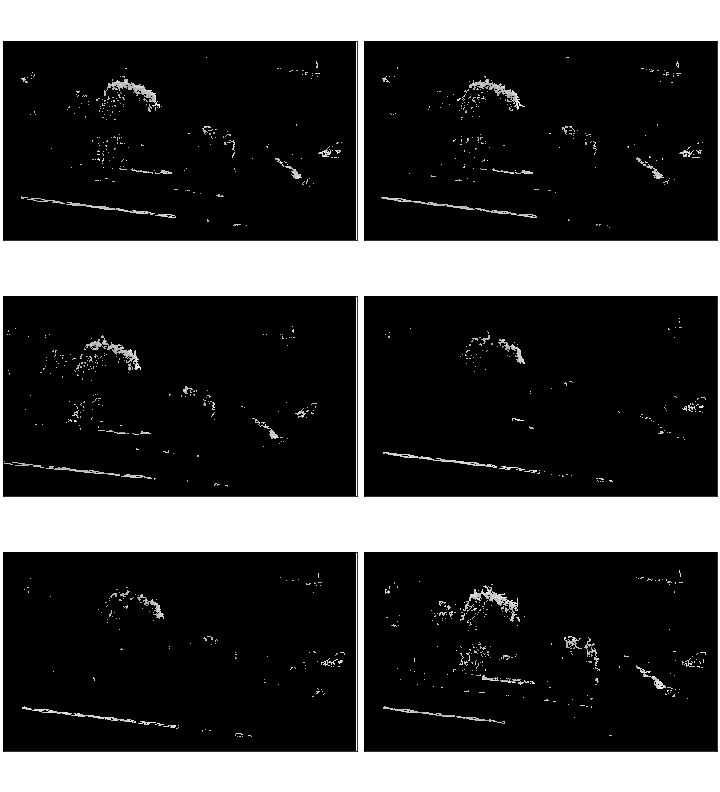

In [179]:
def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, yellow_images))

show_images(gray_images)

### Gaussian Smoothing (Gaussian Blur)

When there is an edge (i.e. a line), the pixel intensity changes rapidly (i.e. from 0 to 255) which we want to detect.  But before doing so, we should make the edges smoother.  As you can see,  the above images have many rough edges which causes many noisy edges to be detected.

I use `cv2.GaussianBlur` to smooth out edges.

- [Gaussian Filter OpenCV Theory](http://docs.opencv.org/doc/tutorials/imgproc/gausian_median_blur_bilateral_filter/gausian_median_blur_bilateral_filter.html#gaussian-filter)
- [cv2.GaussianBlur OpenCV API Reference](http://docs.opencv.org/modules/imgproc/doc/filtering.html?highlight=gaussianblur#gaussianblur)


In [180]:
def apply_smoothing(image, kernel_size=13):
    """
    kernel_size must be postivie and odd
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

The GaussianBlur takes a `kernel_size` parameter which you'll need to play with to find one that works best.  I tried 3, 5, 9, 11, 15, 17 (they must be positive and odd) and check the edge detection (see the next section) result.  The bigger the `kernel_size` value is,  the more blurry the image becomes.  

The bigger `kearnel_size` value requires more time to process. It is not noticeable with the test images but we should keep that in mind (later we'll be processing video clips).  So, we should prefer smaller values if the effect is similar.

<IPython.core.display.Javascript object>


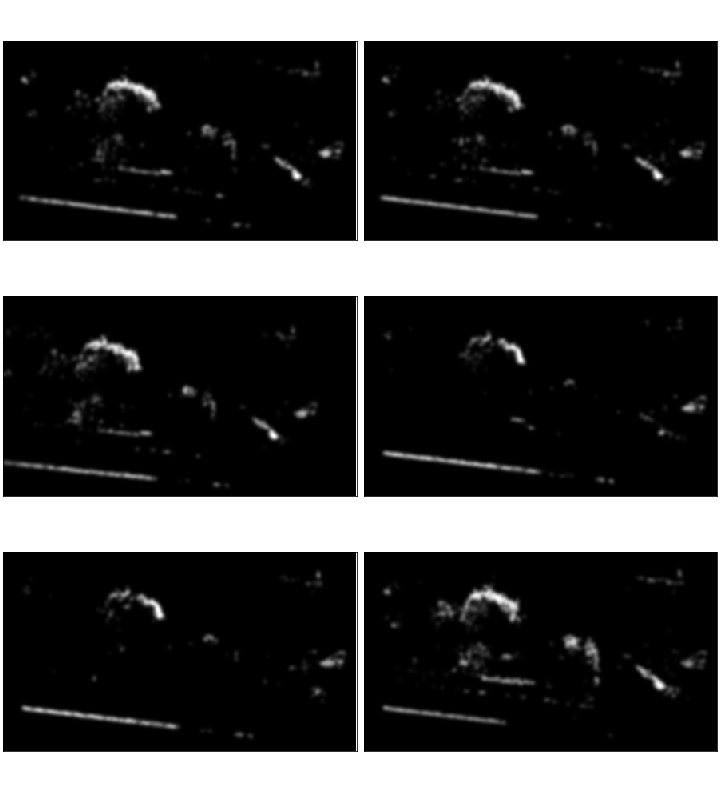

In [181]:
blurred_images = list(map(lambda image: apply_smoothing(image), gray_images))

show_images(blurred_images)

### Edge Detection

`cv2.Canny` takes two threshold values which requires some explanation.

Wikipedia says:

> it is essential to filter out the edge pixel with the weak gradient value and preserve the edge with the high gradient value. Thus two threshold values are set to clarify the different types of edge pixels, one is called high threshold value and the other is called the low threshold value. If the edge pixel’s gradient value is higher than the high threshold value, they are marked as strong edge pixels. If the edge pixel’s gradient value is smaller than the high threshold value and larger than the low threshold value, they are marked as weak edge pixels. If the pixel value is smaller than the low threshold value, they will be suppressed. 

According to the OpenCV documentation, the double thresholds are used as follows:

- If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
- If a pixel gradient value is below the lower threshold, then it is rejected.
- If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold.
- Canny recommended a upper:lower ratio between 2:1 and 3:1.

These two threshold values are empirically determined.  Basically, you will need to define them by trials and errors.

I first set the `low_threshold` to zero and then adjust the `high_threshold`.   If `high_threshold` is too high, you find no edges.  If `high_threshold` is too low, you find too many edges.  Once you find a good `high_threshold`, adjust the `low_threshold` to discard the weak edges (noises) connected to the strong edges.

- [Canny Edge Detection OpenCV Theory](http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html)
- [cv2.Canny OpenCV API Reference](http://docs.opencv.org/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html)

<IPython.core.display.Javascript object>


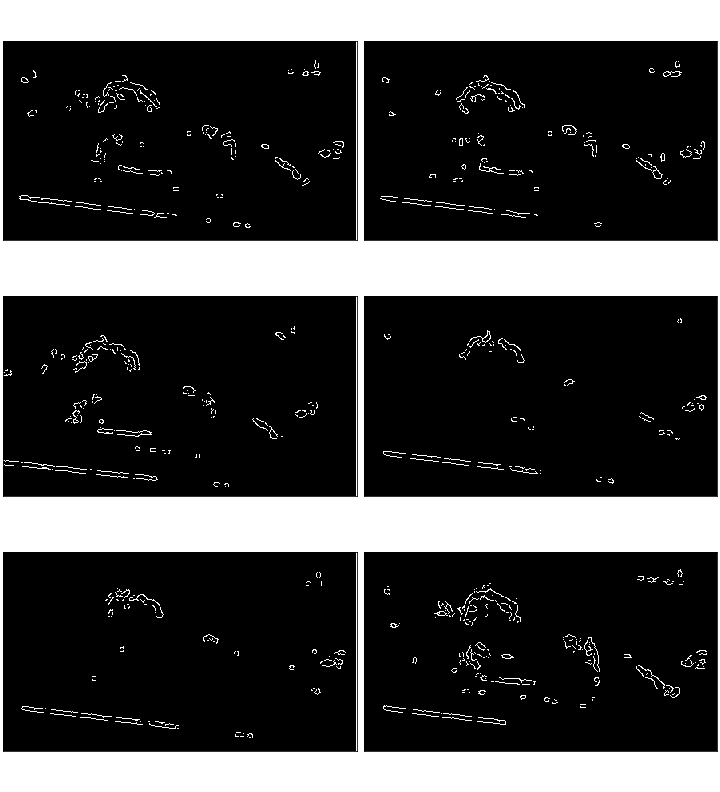

In [182]:
def detect_edges(image, low_threshold=25, high_threshold= 30):
    return cv2.Canny(image, low_threshold, high_threshold)

edge_images = list(map(lambda image: detect_edges(image), blurred_images))

show_images(edge_images)

## Region of Interest Selection

When finding lane lines, we don't need to check the sky and the hills.  

Roughly speaking, we are interested in the aread surrounded by the red lines below:

<img src='./images/region-of-interest.png' width='50%'/>

So, we exclude outside the region of interest by apply a mask.

- [cv2.fillPoly OpenCV API Reference](http://docs.opencv.org/modules/core/doc/drawing_functions.html#fillpoly)

<IPython.core.display.Javascript object>


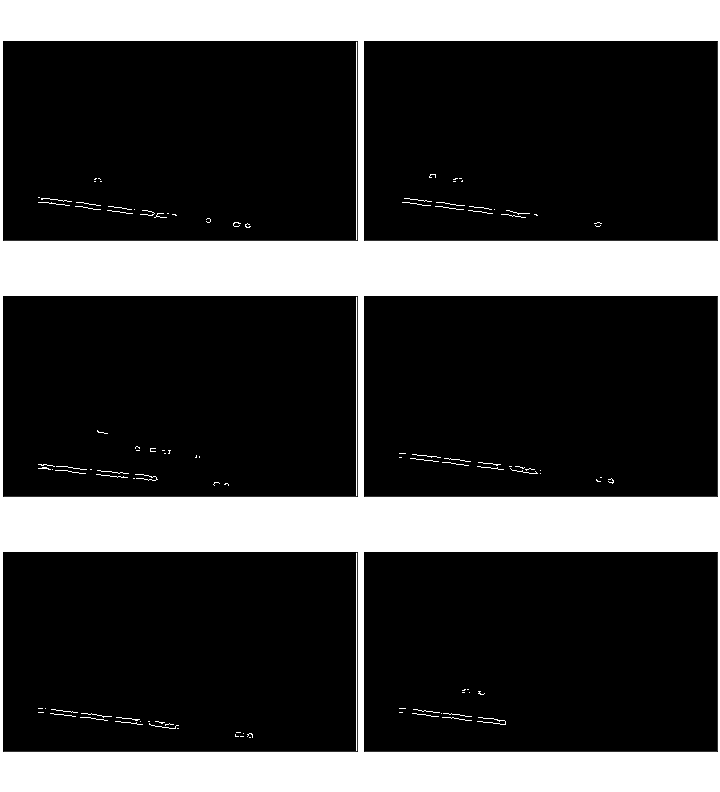

In [236]:
def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

    
def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.1, rows*0.95]
    top_left     = [cols*0.1, rows*0.6]
    bottom_right = [cols*0.9, rows*0.95]
    top_right    = [cols*0.1, rows*0.6] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)


# images showing the region of interest only
roi_images = list(map(select_region, edge_images))

show_images(roi_images)

## Hough Transform Line Detection

I'm using `cv2.HoughLinesP` to detect lines in the edge images.

There are several parameters you'll need to tweak and tune:

- rho – Distance resolution of the accumulator in pixels.
- theta – Angle resolution of the accumulator in radians.
- threshold – Accumulator threshold parameter. Only those lines are returned that get enough votes (> `threshold`).
- minLineLength – Minimum line length. Line segments shorter than that are rejected.
- maxLineGap – Maximum allowed gap between points on the same line to link them.

More details can be found:

- [Hough Line Transform OpenCV Theory](http://docs.opencv.org/doc/tutorials/imgproc/imgtrans/hough_lines/hough_lines.html)
- [cv.HoughLinesP OpenCV API Reference](http://docs.opencv.org/modules/imgproc/doc/feature_detection.html?highlight=houghlinesp#houghlinesp)

In [237]:
def hough_lines(image):
    """
    `image` should be the output of a Canny transform.
    
    Returns hough lines (not the image with lines)
    """
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)


list_of_lines = list(map(hough_lines, roi_images))
print(list_of_lines[0] ) # list of lines detected for one image, each line is  x1, y1, x2, y2 coordinates of the line segment


[[[ 47 202 308 234]]

 [[ 46 197 308 230]]

 [[ 44 196 207 216]]

 [[ 45 203 295 233]]]


`list_of_lines` contains a list of lines detected.  With the above parameters, approximately 2-5 lines are detected for each image.

Let's draw the lines onto the original images.

<IPython.core.display.Javascript object>


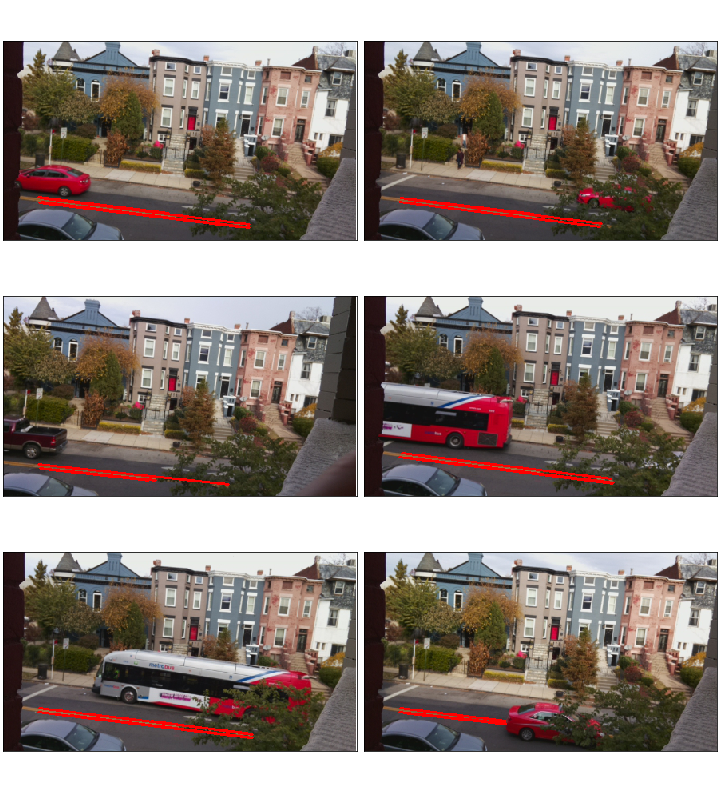

In [284]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image


line_images = []
for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))
    
show_images(line_images)

### Calculating line slope and intercept

There are multiple lines detected for the lane line. We also want to know the intercept and slope of the line so that we can isolate a ROI for our analysis. 

Also, some lane lines are only partially recognized.  We should extrapolate the line to cover full lane line length.
 
Note: in the image, `y` coordinate is reversed.  The higher `y` value is actually lower in the image. So a possitive slope is actually negative.  

In [320]:
def get_slope_intercept(lines):
    intercepts_slopes = [] # (slope, intercept)     
    lengths   = [] # (slope, intercept)
    longest_line = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (float(y2)-float(y1))/(float(x2)-float(x1))
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
             
            intercepts_slopes.append((  slope, intercept))
            lengths.append(( length))

    # return only the longest line 
    longest_line.append( intercepts_slopes[lengths.index(max(lengths))]   )
            
    return longest_line #(slope, intercept) 

In [321]:
 for lines in list_of_lines:
     print(get_slope_intercept(lines))

 

[(0.12595419847328243, 191.20610687022901)]
[(0.12350597609561753, 196.56573705179284)]
[(0.10504201680672269, 205.37815126050421)]
[(0.12359550561797752, 195.56179775280899)]
[(0.12030075187969924, 190.58646616541353)]
[(0.10526315789473684, 196.36842105263159)]


Let's draw the lanes.  I need to convert the slope and intercept into pixel points.

In [326]:
def make_line_points(y1, y2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None
    print(line)
    slope, intercept = line[0]
    
    
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((int(x1), int(y1)), (int(x2), int(y2)))

Our `draw_lines` except a list of lines as the second parameter.  Each line is a list of 4 values (x1, y1, x2, y2).  The data type needs to be integer for `cv2.line` to work without throwing an error.

In [332]:
def lane_lines(image, lines):
    left_lane  = get_slope_intercept(lines)
    
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.6         # slightly lower than the middle

    left_line  = make_line_points(y1, y2, left_lane)
    print(left_line)
    return left_line 
    
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image,  line,  color, thickness)
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)


In [327]:
for image, lines in zip(test_images, list_of_lines):
     lane_lines(image, lines)

[(0.12595419847328243, 191.20610687022901)]
((466, 250), (-327, 150))
[(0.12350597609561753, 196.56573705179284)]
((432, 250), (-377, 150))
[(0.10504201680672269, 205.37815126050421)]
((424, 250), (-527, 150))
[(0.12359550561797752, 195.56179775280899)]
((440, 250), (-368, 150))
[(0.12030075187969924, 190.58646616541353)]
((493, 250), (-337, 150))
[(0.10526315789473684, 196.36842105263159)]
((509, 250), (-440, 150))


In [333]:
lane_images = []
for image, lines in zip(test_images, list_of_lines):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))

    
show_images(lane_images)

[(0.12595419847328243, 191.20610687022901)]
((466, 250), (-327, 150))


SystemError: new style getargs format but argument is not a tuple